In [1]:
import math
import torch
from matplotlib import pyplot as plt
import numpy as np;
import scipy.io
import warnings
warnings.filterwarnings('ignore')
from scipy.linalg import expm
from pssgp.kernels import RBF
from pssgp.model import StateSpaceGP
import tensorflow as tf
import yaml
import gpytorch
import time
from scipy.spatial.transform import Rotation as R

# Load a Dataset

In [2]:
import csv
# reading csv file
filename = 'drag_sim.csv'
fields = []
rows = []
with open(filename, 'r') as csvfile:
    # creating a csv reader object
    csvreader = csv.reader(csvfile)
      
    # extracting field names through first row
    fields = next(csvreader)
  
    # extracting each data row one by one
    for row in csvreader:
        rows.append(row)
  
    # get total number of rows
    print("Total no. of rows: %d"%(csvreader.line_num))
print(fields)

Total no. of rows: 20030
['state_in', 'state_ref', 'error', 'input_in', 'state_out', 'state_pred', 'timestamp', 'dt']


In [3]:
v_world_in = np.zeros((csvreader.line_num-1,3));
v_body_in = np.zeros((csvreader.line_num-1,3));
acc_body_err = np.zeros((csvreader.line_num-1,3));
dt = rows[1][8]
rot_wb_in = np.zeros((csvreader.line_num-1,3,3));
rot_in_check = [1,0,0,0];
rot_pred_check = [1,0,0,0];
rot_out_check = [1,0,0,0];
count =0
for i in range(csvreader.line_num-1):
    state_in = rows[i][1][1:-1]
    state_pred = rows[i][6][1:-1]
    state_out = rows[i][5][1:-1]
    v_world_in[i] = list(map(float, state_in.split(',')))[7:10]
    rot_in = list(map(float, state_in.split(',')))[3:7]
    v_world_out = list(map(float, state_out.split(',')))[7:10]
    rot_out = list(map(float, state_out.split(',')))[3:7]
    v_world_pred = list(map(float, state_pred.split(',')))[7:10]
    rot_pred = list(map(float, state_pred.split(',')))[3:7]
    #Convert to scalar last format
    for j in range(4):
        rot_in_check[j] = rot_in[(j+1)%4]
        rot_pred_check[j] = rot_pred[(j+1)%4]
        rot_out_check[j] = rot_out[(j+1)%4]

    #Input
    rot_wb_in[i] = np.array(R.from_quat(rot_in_check).as_matrix()).T
    v_body_in[i] = np.matmul(rot_wb_in[i],v_world_in[i])
    #prediction
    rot_wb_pred = np.array(R.from_quat(rot_pred_check).as_matrix()).T
    v_body_pred = np.matmul(rot_wb_pred,np.array(v_world_pred))
    #Output
    rot_wb_out = np.array(R.from_quat(rot_out_check).as_matrix()).T
    v_body_out = np.matmul(rot_wb_out ,np.array(v_world_out))
    acc_err = (v_body_out-v_body_pred)/0.01700000000000001
    if np.sum(abs(acc_err))<150:
        v_body_in[count] = np.matmul(rot_wb_in[i],v_world_in[i])
        acc_body_err[count] =acc_err
        count+=1
print(count)
num_data = count
print("Percet Outliers" , 1-count/(csvreader.line_num-1))

19997
Percet Outliers 0.0015976833591292428


# Plot Drag

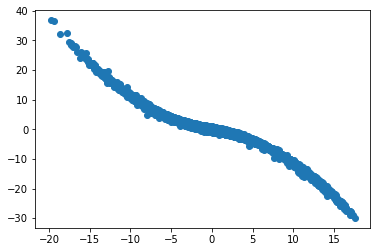

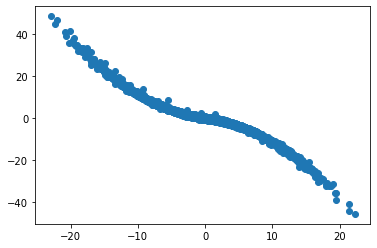

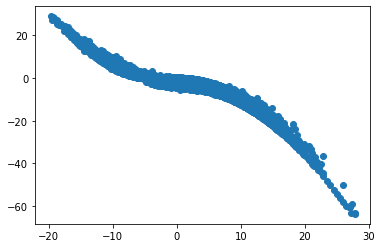

In [4]:
plt.figure()
plt.scatter(v_body_in[:count,0],acc_body_err[:count,0]) #Noise around 1
plt.figure()
plt.scatter(v_body_in[:count,1],acc_body_err[:count,1]) #noise around 2
plt.figure()
plt.scatter(v_body_in[:count,2],acc_body_err[:count,2]) #Noise around 5


In [42]:
##Data processing
#D = scipy.io.loadmat("airline.mat")
xtrain = v_body_in[:num_data,0]/20
y = acc_body_err[:num_data,0]
#xtrain = D["xtrain"]
#y = D["ytrain"]
meanY = np.array(y).sum()/len(y);
std = np.array(y).std();
ytrain = (y-meanY)/std #Divide by standard deviation
#data = (xtrain.astype(float),ytrain.astype(float))
xtrain = torch.tensor(xtrain).float().flatten()
ytrain = torch.tensor(ytrain).float().flatten()
idx = np.sort(np.random.randint(count,size=5000))
#xtrain = xtrain[idx]
#ytrain = ytrain[idx]
idx2 = np.argsort(xtrain)
xtrain = xtrain[idx2]
ytrain = ytrain[idx2]
print(xtrain.shape)
print(ytrain.shape)

torch.Size([19997])
torch.Size([19997])


# Learn Hyperparameters

In [43]:
# GP Model Kernel is a parameter.
class GPModel(gpytorch.models.ExactGP):
    def __init__(self,train_x, train_y, likelihood, kernel):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel; ##Kernel function

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
##Function that plots the kernel confidence region + sample functions
def plotFpred(f_preds, xtrain,ytrain,xtest,meanY, std, KernelStr):
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 2, figsize=(9, 4))
        # Get upper and lower confidence bounds
        lower, upper = f_preds.confidence_region()
        lower = lower*std +meanY
        upper = upper*std +meanY
        ytrain = ytrain*std + meanY
        # Plot training data as black stars
        ax[0].plot(xtrain, ytrain, 'k*')
        # Plot predictive means as blue line
        ax[0].plot(xtest, f_preds.mean*std+meanY, 'b')
        # Shade between the lower and upper confidence bounds
        ax[0].fill_between(xtest.numpy(), lower.numpy(),
                           upper.numpy(), alpha=0.5)
        ax[0].legend(['Observed Data', 'Mean', 'Confidence'])
        ax[0].set_title(KernelStr + 'Confidence')
        ax[1].plot(xtrain, ytrain, 'k*')
        # Plot predictive means as blue line
        f_samples = f_preds.rsample(sample_shape = torch.Size([2]))
        for samples in f_samples.detach():
            ax[1].plot(xtest, samples*std+meanY)
        ax[1].set_title(KernelStr + 'Sample Functions')

def train(model, likelihood, train_x, train_y):# Find optimal model hyperparameters
    model.train()
    likelihood.train()
    training_iter =20;
    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        print(loss)
        
def test(model, likelihood, test_x):
    model.eval() ##Test takes model returns output
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        f_preds = likelihood(model(test_x)) 
    return f_preds

def train_plot(Currkernel,xtrain,ytrain,xtest,meanY, 
               std,noise, KernelStr, ytest=None):
    likelihood = gpytorch.likelihoods.GaussianLikelihood() ##One function to call both train and plot
    likelihood.noise_covar.noise =noise # CovarNoise rescaled by std
    model  =  GPModel(xtrain , ytrain , likelihood, Currkernel)
    train(model, likelihood, xtrain, ytrain)
    start = time.time()
    f_preds= test(model, likelihood, xtest)
    end = time.time()
    print("time: ", end - start)
    if ytest is None: ##Switch for part 4 function plotting
        plotFpred(f_preds, xtrain,ytrain,xtest,meanY, std, KernelStr)
    else:
        plotFpred(f_preds, xtest,ytest,xtest,meanY, std, KernelStr)
    return model

tensor(2.0743, grad_fn=<NegBackward>)
tensor(2.0691, grad_fn=<NegBackward>)
tensor(2.0639, grad_fn=<NegBackward>)
tensor(2.0585, grad_fn=<NegBackward>)
tensor(2.0532, grad_fn=<NegBackward>)
tensor(2.0478, grad_fn=<NegBackward>)
tensor(2.0424, grad_fn=<NegBackward>)
tensor(2.0369, grad_fn=<NegBackward>)
tensor(2.0314, grad_fn=<NegBackward>)
tensor(2.0258, grad_fn=<NegBackward>)
tensor(2.0202, grad_fn=<NegBackward>)
tensor(2.0145, grad_fn=<NegBackward>)
tensor(2.0087, grad_fn=<NegBackward>)
tensor(2.0029, grad_fn=<NegBackward>)
tensor(1.9970, grad_fn=<NegBackward>)
tensor(1.9911, grad_fn=<NegBackward>)
tensor(1.9850, grad_fn=<NegBackward>)
tensor(1.9789, grad_fn=<NegBackward>)
tensor(1.9726, grad_fn=<NegBackward>)
tensor(1.9663, grad_fn=<NegBackward>)
time:  16.627797603607178
Parameter name: likelihood.noise_covar.raw_noise           value = 7.975352764129639
Parameter name: mean_module.constant                       value = 0.017339788377285004
Parameter name: covar_module.raw_lengthsc

<Figure size 432x288 with 0 Axes>

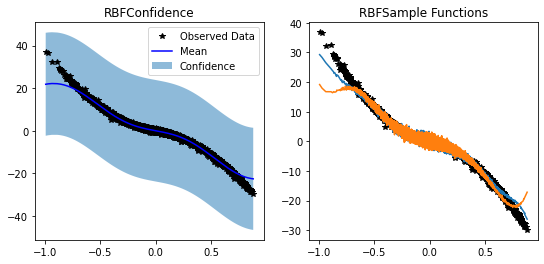

In [44]:
Currkernel = gpytorch.kernels.RBFKernel()
#Currkernel.outputscale = 1;
Currkernel.lengthscale = 0.1;
plt.figure()
model = train_plot(Currkernel,xtrain,ytrain,xtrain,meanY,std,10, "RBF")
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

In [45]:
constraint = model.covar_module.raw_lengthscale_constraint
print(constraint.transform(model.covar_module.raw_lengthscale))
print(constraint.transform(model.likelihood.noise_covar.raw_noise))


tensor([[0.4239]], grad_fn=<SoftplusBackward>)
tensor([7.9757], grad_fn=<SoftplusBackward>)


# PLOT FUNCTION

In [54]:
def plotSSM(test_x, preds, lower, upper,  xtrain, ytrain):
    fig = plt.figure()
    # Get upper and lower confidence bounds
    # Plot training data as black stars
    plt.plot(xtrain, ytrain, 'k*')
    # Plot predictive means as blue line
    plt.plot(test_x, preds, 'r')
    # Shade between the lower and upper confidence bounds
    plt.fill_between(test_x, lower,
                       upper, alpha=0.5)
    plt.legend(['Observed Data', 'Mean', 'Confidence'])
    #plt.xlim(0,120)
    #plt.ylim(50,450)

# Create the State Space Model

In [47]:
noise_variance = 0.0315 #LEARN HYPERPARAMETERS LATER 
lengthscale = 0.2841
variance =0.0368

order = 6  # Order of the RBF approximation for (P)SSGP, will not be used if the GP model is GPR1515
balancing_iter = 5  # Number of balancing steps for the resulting SDE to make it more stable, will not be used if the GP model is GPR
cov = RBF(variance=variance, lengthscales=lengthscale, order=order, balancing_iter=balancing_iter)

In [48]:
discrete_model = cov.get_sde()
print(discrete_model[4]*15)

tf.Tensor([[3.32451997]], shape=(1, 1), dtype=float64)


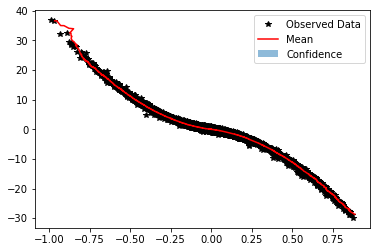

In [62]:
discrete_model = cov.get_sde()
P_inf = discrete_model[0].numpy();
F = discrete_model[1].numpy();
L = discrete_model[2].numpy();
H = discrete_model[3].numpy();
Q = discrete_model[4].numpy()*15; 

class KalmanFilter:
    def __init__(self,A,B,C,Q,R):
        self.A = A
        self.B = B
        self.C = C
        self.Q = Q
        self.R = 0.0315
        self.const = np.zeros((order*2,order))
        self.const[order:order*2,:] = np.identity(order)
        
    def calc_Qs(self,dt):
        Qs = np.zeros((order*2,order*2))
        Qs[:order,:order]=self.A
        Qs[order:order*2,order:order*2]=-self.A.T
        Qs[:order,order:order*2]=np.matmul(self.B,self.B.T)*self.Q
        Qs = expm(Qs*dt)
        Qs = np.matmul(Qs[:order,order:order*2],(expm(self.A*dt).T));
        return Qs
    
    def predict(self,xt,covar,dt):
        #xt_1 = np.matmul(self.A,xt)*dt+xt
        A_now = expm(self.A*dt)
        xt_1 = np.matmul(A_now,xt)
        #diff = xt_1- np.matmul(self.A,xt)*dt-xt
        covar_t1 = np.matmul(np.matmul(A_now,covar),A_now.T)+self.calc_Qs(dt)
        covar_t1 = (covar_t1+covar_t1.T)*0.5;
        return xt_1,covar_t1
    def update(self,zt,xt,covar):
        S = np.matmul(np.matmul(self.C,covar),self.C.T)+self.R
        Kt = np.matmul(covar,self.C.T)/S[0,0]
        covar_t1 = covar - np.matmul(Kt,Kt.T)*S[0,0]
        xt_1 = xt+Kt*(zt-np.matmul(self.C,xt))
        return xt_1,covar_t1
    
model = KalmanFilter(F,L,H,Q,variance)
xtrain_kal = xtrain.numpy()
length = xtrain_kal.shape[0]
xt = np.zeros((order,1))
xt[0,0] =  ytrain[0]
covar = P_inf;
y_predict = np.zeros(length)
x_interpol = np.zeros(length*10)
low_interpol = np.zeros(length*10)
y_interpol = np.zeros(length*10)
high_interpol = np.zeros(length*10)
y_predict[0] = xt[0]
t=xtrain_kal[0]
count =0
for i in range(1,length):
    dt = xtrain_kal[i]-xtrain_kal[i-1]
    if(dt<0):
        print(dt)
    t+=dt
    xt_p,covar_p = model.predict(xt,covar,dt)
    xt,covar = model.update(ytrain[i].numpy(),xt_p,covar_p)    
    y_predict[i] = xt_p[0]    
    for j in range(1,5):
        x_interpol[count]=t+dt*j/5
        xt,covar = model.predict(xt,covar,dt/5)
        y_interpol[count] = xt[0]
        low_interpol[count] = xt[0]-covar[0,0]/2
        high_interpol[count] = xt[0]+covar[0,0]/2
        count = count +1
#idx2 = np.argsort(x_interpol)
#x_interpol = x_interpol[idx2]
#y_interpol_p = y_interpol_p[idx2]
#low_interpol_p = low_interpol_p[idx2]
#high_interpol_p = high_interpol_p[idx2]
y_predict_p = y_predict*std+meanY
ytrain_p= ytrain*std+meanY
y_interpol_p = y_interpol*std+meanY
low_interpol_p = low_interpol*std+meanY
high_interpol_p = high_interpol*std+meanY
plotSSM(x_interpol[:count], y_interpol_p[:count], low_interpol_p[:count], high_interpol_p[:count],  xtrain, ytrain_p)

In [50]:
print(model.calc_Qs(-1))

[[-1.43283454e+10  4.34674297e+10 -5.83052863e+10  4.13661459e+10
  -1.58264362e+10  3.21134381e+09]
 [ 4.34674297e+10 -1.32105262e+11  1.77546715e+11 -1.26230896e+11
   4.84052639e+10 -9.84596375e+09]
 [-5.83052863e+10  1.77546715e+11 -2.39123517e+11  1.70399980e+11
  -6.55051074e+10  1.33599803e+10]
 [ 4.13661459e+10 -1.26230896e+11  1.70399980e+11 -1.21730603e+11
   4.69231053e+10 -9.59845361e+09]
 [-1.58264362e+10  4.84052639e+10 -6.55051074e+10  4.69231053e+10
  -1.81413763e+10  3.72309197e+09]
 [ 3.21134381e+09 -9.84596375e+09  1.33599803e+10 -9.59845361e+09
   3.72309197e+09 -7.66837199e+08]]


In [59]:
bins = np.arange(-1, 0.8, 0.05, dtype=float)
ybins = np.zeros(bins.shape[0])
xbins = np.zeros(bins.shape[0])
count = 0;
for i in range(bins.shape[0]):
    index1 = bins[i];
    while xtrain[count] < index1:
        count+=1
    xbins[i] = xtrain[count]
    ybins[i] = ytrain[count]

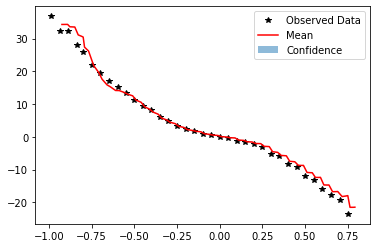

In [63]:
model = KalmanFilter(F,L,H,Q,variance)
xtrain_kal = xbins
length = bins.shape[0]
xt = np.zeros((order,1))
xt[0,0] =  ytrain[0]
covar = P_inf;
y_predict = np.zeros(length)
x_interpol = np.zeros(length*10)
low_interpol = np.zeros(length*10)
y_interpol = np.zeros(length*10)
high_interpol = np.zeros(length*10)
y_predict[0] = xt[0]
t=xtrain_kal[0]
count =0
for i in range(1,length):
    dt = xtrain_kal[i]-xtrain_kal[i-1]
    if(dt<0):
        print(dt)
    t+=dt
    xt_p,covar_p = model.predict(xt,covar,dt)
    xt,covar = model.update(ybins[i],xt_p,covar_p)    
    y_predict[i] = xt_p[0]    
    for j in range(1,5):
        x_interpol[count]=t+dt*j/5
        xt,covar = model.predict(xt,covar,dt/5)
        y_interpol[count] = xt[0]
        low_interpol[count] = xt[0]-covar[0,0]/2
        high_interpol[count] = xt[0]+covar[0,0]/2
        count = count +1
#idx2 = np.argsort(x_interpol)
#x_interpol = x_interpol[idx2]
#y_interpol_p = y_interpol_p[idx2]
#low_interpol_p = low_interpol_p[idx2]
#high_interpol_p = high_interpol_p[idx2]
y_predict_p = y_predict*std+meanY
ytrain_p= ybins*std+meanY
y_interpol_p = y_interpol*std+meanY
low_interpol_p = low_interpol*std+meanY
high_interpol_p = high_interpol*std+meanY
plotSSM(x_interpol[:count], y_interpol_p[:count], low_interpol_p[:count], high_interpol_p[:count],  xbins, ytrain_p)

###### 

In [56]:
discrete_model = cov.get_sde()
P_inf = discrete_model[0].numpy().flatten().tolist();
F = discrete_model[1].numpy().flatten().tolist();
L = discrete_model[2].numpy().flatten().tolist();
H = discrete_model[3].numpy().flatten().tolist();
Q = (discrete_model[4].numpy()*15).flatten().tolist(); 
xtrain_yaml = xbins.flatten().tolist(); 
ytrain_yaml = ybins.flatten().tolist(); 
meanY_yaml = meanY.tolist();
std_yaml = std.tolist();
dict_file = [{'Order' : order},{'P_inf' : P_inf},{'F' : F},{'L' : L},{'H' : H},{'Q' : Q},{'xtrain' : xtrain_yaml},{'ytrain' : ytrain_yaml},{'xScale' : 20},{'meanY' : meanY_yaml},{'std':std_yaml}]

with open('model_params.yaml', 'w') as file:
    documents = yaml.dump(dict_file, file)

# Check the Local Approximation 

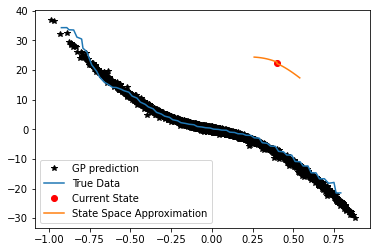

<Figure size 432x288 with 0 Axes>

In [57]:
plt.plot(xtrain, ytrain*std+meanY, 'k*')
plt.plot(x_interpol[:count], y_interpol_p[:count])
t_test = 0.4
i=0
t=xtrain_kal[0];
extraSamples = 15;
x_dropoff = np.zeros(extraSamples*2);
y_dropoff = np.zeros(extraSamples*2);
while xtrain_kal[i] < t_test:
    dt = xtrain_kal[i+1]- xtrain_kal[i]
    t+=dt
    xt_p,covar_p = model.predict(xt,covar,dt)
    xt,covar = model.update(ytrain[i].numpy(),xt_p,covar_p)
    i+=1
xt_p=xt
dt = 0.01
covar_p = covar;
plt.plot(t_test,xt[0]*std+meanY,'ro')
t_lead = t
for i in range(extraSamples):
    x_dropoff[extraSamples-i-1]=t_lead
    xt_p,covar_p = model.predict(xt_p,covar_p,-1*dt)
    #print(xt_p)
    y_dropoff[extraSamples-i-1]=xt_p[0]
    t_lead-=dt;
xt_p=xt
covar_p = covar;
t_lead = t
for i in range(extraSamples):
    x_dropoff[i+extraSamples]=t_lead
    xt_p,covar_p = model.predict(xt_p,covar_p,dt)
    #print(xt_p)
    y_dropoff[i+extraSamples]=xt_p[0]
    t_lead+=dt;
plt.plot(x_dropoff,y_dropoff*std+meanY)
plt.legend(['GP prediction', 'True Data','Current State','State Space Approximation'])

plt.figure();


# Convert Parameters to YAML file